# ● Libraries

In [469]:
import numpy as np
import cv2
import os
import glob
import matplotlib.pyplot as plt
import math
from scipy import ndimage
from skimage import data, filters
from skimage import img_as_float
from sklearn.cluster import KMeans, MeanShift
from skimage.measure import label as skilabel
from skimage.segmentation import (morphological_chan_vese,
                                  checkerboard_level_set)
from skimage.feature import local_binary_pattern
from skimage.feature.texture import greycomatrix, greycoprops
from scipy.stats import skew
from skimage.measure import label, regionprops
from scipy import interp
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.metrics import roc_curve, auc, accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
import time
import seaborn as sn
import pandas as pd
import time
import tqdm
import dill

# ● Dataset

In [470]:
def sortData(path):
    """"
    Input:  path
    Output: data[p] = {
        'id':
        'image':
        'label': }
        
    """
    # Importing Images
    les_dir = glob.glob(path+"/les/*.jpg")
    nv_dir  = glob.glob(path+"/nv/*.jpg")

    print("Number of LES Images:", len(les_dir))
    print("Number of NV Images:",  len(nv_dir))

    # Creating Dictionary (LES Scans)
    data = {}
    for p in range(len(les_dir)):
        scan_id  =  les_dir[p].replace(".jpg", "")
        scan_id  =  scan_id.replace(path+"/les\\", "")

        # Creating list of dictionary                    
        data[p] = {
                    'id'    : scan_id,
                    'image' : les_dir[p],
                    'label' : 0 }            # Label of LES = 0
    
    # Creating Dictionary (NV Scans)
    for p in range(len(nv_dir)):
        scan_id  =  nv_dir[p].replace(".jpg", "")
        scan_id  =  scan_id.replace(path+"/nv\\", "")

        # Creating list of dictionary                    
        data[p+len(les_dir)] = {
                    'id'    : scan_id,
                    'image' : nv_dir[p],
                    'label' : 1 }            # Label of NV = 1
        
    return data

def findScan(data,name,key):
    """"
    Input: 
        data     - dict of dict to sort the data
        key      - key of 'data' ('id','image','label')
        value    - value of 'key'
    Output:
        value
    """
    for i, dic in data.items():
        if dic[key] == name:        
            return i
    return -1

In [471]:
train_data = sortData('../data/train')           # Load Training Set

Number of LES Images: 2400
Number of NV Images: 2400


In [472]:
val_data   = sortData('../data/val')             # Load Validation Set

Number of LES Images: 600
Number of NV Images: 600


In [473]:
# Pass Target Image (Example)
index1  = findScan(train_data,'ls0930','id')
sample1 = plt.imread(train_data[index1]['image'])
#index2  = findScan(train_data,'ls0179','id')
index2  = findScan(train_data,'ls0001','id')
sample2 = plt.imread(train_data[index2]['image'])
index3  = findScan(train_data,'nv4362','id')
sample3 = plt.imread(train_data[index3]['image'])

# ● Preprocessing

## White-Balance (Color Constancy)

In [474]:
def color_constant(img):
    
    # Extract Color Channels
    img_R = img[:,:,0]
    img_G = img[:,:,1]
    img_B = img[:,:,2]    
    
    # Calculate Channel Averages
    avg_R = np.mean(img_R)
    avg_G = np.mean(img_G)
    avg_B = np.mean(img_B)
    avg_all = np.mean(img)
    
    # Calculate Scaling Factor for White-Balance
    scale_R = (avg_all / avg_R)
    scale_G = (avg_all / avg_G)
    scale_B = (avg_all / avg_B)
    
    # Transform to White-Balance
    img_new = np.zeros(img.shape)
    img_new[:,:,0] = scale_R * img_R  
    img_new[:,:,1] = scale_G * img_G 
    img_new[:,:,2] = scale_B * img_B  
    
    # Normalize Images
    max_intensity = np.max(np.max(np.max(img_new)))
    min_intensity = np.min(np.min(np.min(img_new)))
    
    img_normalized = (((img_new - min_intensity) / (max_intensity - min_intensity))*255).astype(np.uint8)

    # Illuminant Profile (Gray World Color Constancy) 
    illuminance = [avg_R, avg_G, avg_B]
    
    return img_normalized, illuminance

def white_balance(img):
    result = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)                                              # Convert to LAB Color Space
    avg_a  = np.average(result[:, :, 1])
    avg_b  = np.average(result[:, :, 2])
    result[:, :, 1] = result[:, :, 1] - ((avg_a - 128) * (result[:, :, 0] / 255.0) * 1.1)      # Grey World Color Transform (A)
    result[:, :, 2] = result[:, :, 2] - ((avg_b - 128) * (result[:, :, 0] / 255.0) * 1.1)      # Grey World Color Transform (B)
    result = cv2.cvtColor(result, cv2.COLOR_LAB2RGB)
    return result

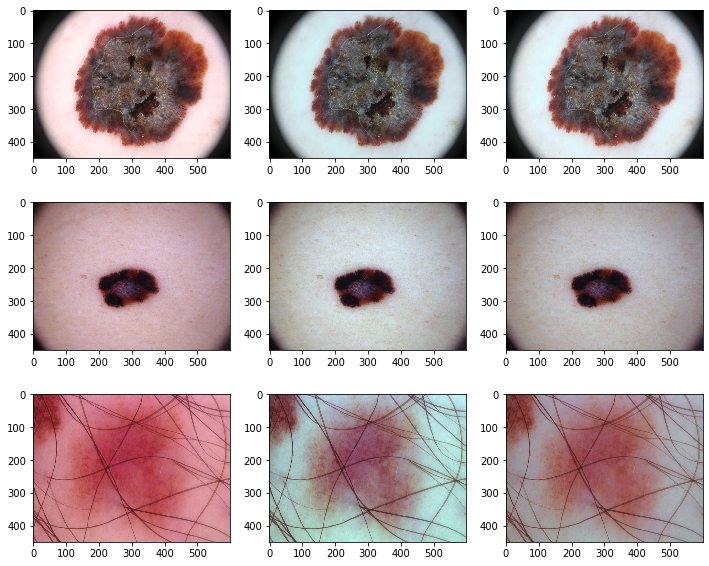

In [475]:
# Color-Constant Transformation
wb1,_ = color_constant(sample1)
wb2,_ = color_constant(sample2)
wb3,_ = color_constant(sample3)

# White-Balance Transformation
wb11 = white_balance(sample1)
wb22 = white_balance(sample2)
wb33 = white_balance(sample3)


plt.figure(figsize=[12,10])
plt.subplot(331)
plt.imshow(sample1)
plt.subplot(332)
plt.imshow(wb1)
plt.subplot(333)
plt.imshow(wb11)
plt.subplot(334)
plt.imshow(sample2)
plt.subplot(335)
plt.imshow(wb2)
plt.subplot(336)
plt.imshow(wb22)
plt.subplot(337)
plt.imshow(sample3)
plt.subplot(338)
plt.imshow(wb3)
plt.subplot(339)
plt.imshow(wb33)

## Contrast-Limited Adaptive Histogram Equalization (CLAHE)

In [476]:
def clahe_RGB(img,clip=0.9,tile=1):

    lab        = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)                          # Convert to LAB Color Space
    clahe      = cv2.createCLAHE(clipLimit=clip, tileGridSize=(tile,tile))     # Create CLAHE Function
    lab[:,:,0] = clahe.apply(lab[:,:,0])                                       # Apply Transformation
    output     = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)                          # Convert to LAB Color Space
   
    return output

## Occlusion Removal (Hair)

In [477]:
def occlusion_removal(img,threshold=20,SE_radius=13,minArea=50000):
    
    # REMOVE BLACK HAIR LINES
    # Convert to LUV Color Space
    luv       = cv2.cvtColor(img, cv2.COLOR_RGB2Luv)

    # Morphological Closing via Spherical SE
    kernel    = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(SE_radius,SE_radius))
    closing   = cv2.morphologyEx(luv, cv2.MORPH_CLOSE, kernel)

    # Generate Masks via Hysteresis Thresholding Difference Image in L Channel
    diffc      = closing[:,:,0]-luv[:,:,0]
    maskc      = (filters.apply_hysteresis_threshold(diffc,threshold,80)).astype(np.uint8)*255
    
    # Remove Side Components
    label_im, nb_labels = ndimage.label(maskc)
    sizes               = ndimage.sum(maskc, label_im, range(nb_labels + 1))
    temp_mask           = sizes > minArea
    maskc               = (temp_mask[label_im]*255).astype(np.uint8)
  
    mask_3dc   = maskc[:,:,None] * np.ones(3,dtype=np.uint8)[None, None, :]
    basec      = cv2.bitwise_not(maskc)
    base_3dc   = basec[:,:,None] * np.ones(3,dtype=np.uint8)[None, None, :]

    # Restitch Preprocessed Image
    preimagec  = ((base_3dc/255)*luv).astype(np.uint8)
    postimagec = ((mask_3dc/255)*closing).astype(np.uint8)
    fullc      = preimagec + postimagec
    outputc    = cv2.cvtColor(fullc, cv2.COLOR_Luv2RGB)

    return outputc,maskc

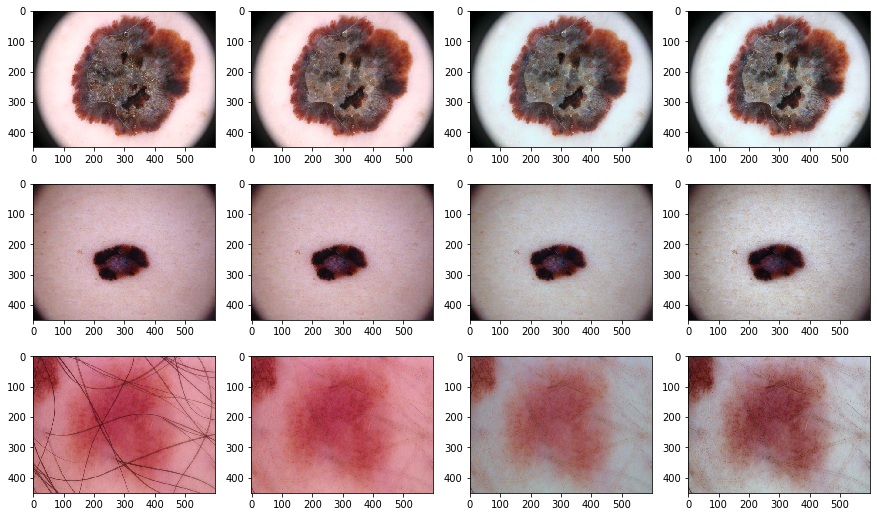

In [478]:
# Occlusion Removal
hr1,mask1 = occlusion_removal(sample1)
hr2,mask2 = occlusion_removal(sample2)
hr3,mask3 = occlusion_removal(sample3)

# White-Balance Transformation
wb1 = white_balance(hr1)
wb2 = white_balance(hr2)
wb3 = white_balance(hr3)

# CLAHE Preprocessing
cl1   = clahe_RGB(wb1)
cl2   = clahe_RGB(wb2)
cl3   = clahe_RGB(wb3)

plt.figure(figsize=[15,9])
plt.subplot(341)
plt.imshow(sample1)
plt.subplot(342)
plt.imshow(hr1)
plt.subplot(343)
plt.imshow(wb1)
plt.subplot(344)
plt.imshow(cl1)
plt.subplot(345)
plt.imshow(sample2)
plt.subplot(346)
plt.imshow(hr2)
plt.subplot(347)
plt.imshow(wb2)
plt.subplot(348)
plt.imshow(cl2)
plt.subplot(349)
plt.imshow(sample3)
plt.subplot(3,4,10)
plt.imshow(hr3)
plt.subplot(3,4,11)
plt.imshow(wb3)
plt.subplot(3,4,12)
plt.imshow(cl3)

# ● Segmentation

In [479]:
def getLargestCC(segmentation):
    labels = skilabel(segmentation)
    assert( labels.max() != 0 ) # assume at least 1 CC
    largestCC = labels == np.argmax(np.bincount(labels.flat)[1:])+1
    return largestCC

def create_circular_mask(h, w, center=None, radius=None):
    if center is None: # use the middle of the image
        center = [int(w/2), int(h/2)]
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])
    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)
    mask = dist_from_center <= radius
    return mask

def store_evolution_in(lst):
    def _store(x):
        lst.append(np.copy(x))
    return _store

def corner_mean(img, limit=30):
    # Average Intensity at Corners
    LT = img[:limit,:limit].mean()
    LB = img[img.shape[0]-limit:,:limit].mean()
    RT = img[:limit,img.shape[1]-limit:].mean()
    RB = img[img.shape[0]-limit:,img.shape[1]-limit:].mean()
    return np.mean((LT,LB,RT,RB))
    
def segment_lesion(img): 
    # Morphological ACWE
    image     = img_as_float(img)
    
    # Initial level Set
    init_ls   = checkerboard_level_set(image.shape, 6)
        
    # List with Intermediate Results for Plotting the Evolution
    evolution = []
    callback  = store_evolution_in(evolution)
    ls        = morphological_chan_vese(image, 5, init_level_set=init_ls, smoothing=10, iter_callback=callback)
    count_w   = sum(sum(ls == 1))
    count_b   = ls.shape[0]*ls.shape[1] - count_w
    
    # For Radial-Black Scope Images
    if (corner_mean(img)>10):
        if count_b < count_w:  
            ls = 255 - ls
            ls[ls == 255] = 1
            ls[ls == 254] = 0
    
    # Discard Edge-to-Edge Connected Component
    try:
        large = getLargestCC(ls).astype(np.uint8)
        if (corner_mean(large)==1):
            large = getLargestCC(ls-large).astype(np.uint8)
    except:
        large = create_circular_mask(image.shape[0], image.shape[1], radius = 200).astype(bool)

    # Post-Process Masks
    post      = getLargestCC(ndimage.binary_fill_holes(large, structure=np.ones((5,5))).astype(bool)).astype(np.uint8)
    post      = cv2.dilate(post,np.ones((5,5)),iterations = 1)
    
    # Redundancy Check             
    checker        = create_circular_mask(post.shape[0], post.shape[1], radius = 200).astype(bool)
    target_area    = checker*post
    count_scope    = sum(sum(checker==1))
    count_target   = sum(sum(target_area==1))
    if (count_target<(0.35*count_scope)):
            post = create_circular_mask(post.shape[0], post.shape[1], radius = 200).astype(bool)
    return post.astype(bool)

In [480]:
mask1 = segment_lesion(cv2.cvtColor(cl1, cv2.COLOR_RGB2GRAY))
mask2 = segment_lesion(cv2.cvtColor(cl2, cv2.COLOR_RGB2GRAY))
mask3 = segment_lesion(cv2.cvtColor(cl3, cv2.COLOR_RGB2GRAY))

mask1_GL                 = mask1.astype(bool)
img1_GL                  = cv2.cvtColor(cl1, cv2.COLOR_RGB2GRAY) 
lesion1_GL               = np.multiply(img1_GL,mask1_GL)    
compressed_lesion1_GL    = np.ma.array(lesion1_GL,mask=~mask1_GL)

mask2_GL                 = mask2.astype(bool)
img2_GL                  = cv2.cvtColor(cl2, cv2.COLOR_RGB2GRAY) 
lesion2_GL               = np.multiply(img2_GL,mask2_GL)    
compressed_lesion2_GL    = np.ma.array(lesion2_GL,mask=~mask2_GL)

mask3_GL                 = mask3.astype(bool)
img3_GL                  = cv2.cvtColor(cl3, cv2.COLOR_RGB2GRAY) 
lesion3_GL               = np.multiply(img3_GL,mask3_GL)    
compressed_lesion3_GL    = np.ma.array(lesion3_GL,mask=~mask3_GL)

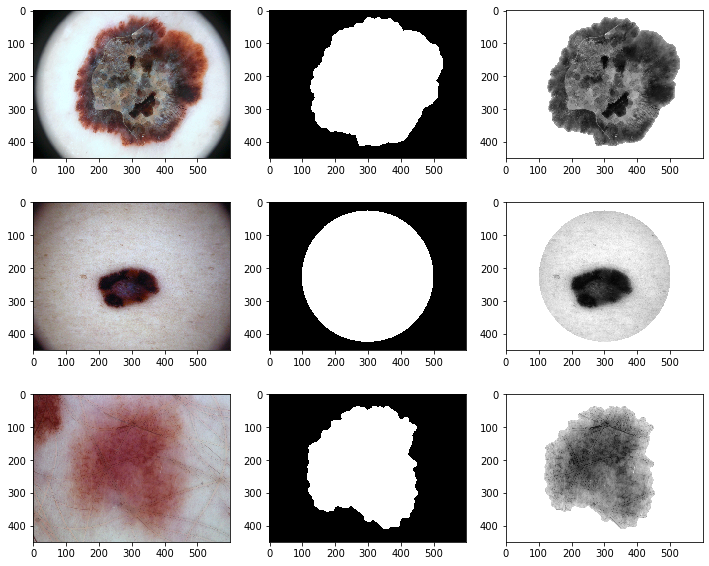

In [481]:
plt.figure(figsize=[12,10])
plt.subplot(331)
plt.imshow(cl1)
plt.subplot(332)
plt.imshow(mask1,cmap='gray')
plt.subplot(333)
plt.imshow(compressed_lesion1_GL,cmap='gray')
plt.subplot(334)
plt.imshow(cl2)
plt.subplot(335)
plt.imshow(mask2,cmap='gray')
plt.subplot(336)
plt.imshow(compressed_lesion2_GL,cmap='gray')
plt.subplot(337)
plt.imshow(cl3)
plt.subplot(338)
plt.imshow(mask3,cmap='gray')
plt.subplot(339)
plt.imshow(compressed_lesion3_GL,cmap='gray')

# ● Feature Extraction

In [496]:
def extract_features(image,mask):
    
    # Color Spaces
    img_RGB                 = image
    img_HSV                 = cv2.cvtColor(img_RGB, cv2.COLOR_RGB2HSV)
    img_LAB                 = cv2.cvtColor(img_RGB, cv2.COLOR_RGB2Lab)
    img_YCrCb               = cv2.cvtColor(img_RGB, cv2.COLOR_RGB2YCrCb)
    img_GL                  = cv2.cvtColor(img_RGB, cv2.COLOR_RGB2GRAY)
    mask                    = mask.astype(bool) 
      
    compressed_lesion_GL    = np.ma.array(np.multiply(img_GL,mask)          ,mask=~mask)
    compressed_lesion_R     = np.ma.array(np.multiply(img_RGB[:,:,0],mask)  ,mask=~mask)
    compressed_lesion_G     = np.ma.array(np.multiply(img_RGB[:,:,1],mask)  ,mask=~mask)
    compressed_lesion_B     = np.ma.array(np.multiply(img_RGB[:,:,2],mask)  ,mask=~mask)
    compressed_lesion_H     = np.ma.array(np.multiply(img_HSV[:,:,0],mask)  ,mask=~mask)
    compressed_lesion_S     = np.ma.array(np.multiply(img_HSV[:,:,1],mask)  ,mask=~mask)
    compressed_lesion_V     = np.ma.array(np.multiply(img_HSV[:,:,2],mask)  ,mask=~mask)
    compressed_lesion_L     = np.ma.array(np.multiply(img_LAB[:,:,0],mask)  ,mask=~mask)
    compressed_lesion_a     = np.ma.array(np.multiply(img_LAB[:,:,1],mask)  ,mask=~mask)
    compressed_lesion_b     = np.ma.array(np.multiply(img_LAB[:,:,2],mask)  ,mask=~mask)
    compressed_lesion_Y     = np.ma.array(np.multiply(img_YCrCb[:,:,0],mask),mask=~mask)
    compressed_lesion_Cr    = np.ma.array(np.multiply(img_YCrCb[:,:,1],mask),mask=~mask)
    compressed_lesion_Cb    = np.ma.array(np.multiply(img_YCrCb[:,:,2],mask),mask=~mask)
    
    

    # Color Moments
    mean_R = np.mean(compressed_lesion_R)
    mean_G = np.mean(compressed_lesion_G)
    mean_B = np.mean(compressed_lesion_B)
    std_R = np.std(compressed_lesion_R)
    std_G = np.std(compressed_lesion_G)
    std_B = np.std(compressed_lesion_B)
    skew_R = skew(compressed_lesion_R.reshape(-1))
    skew_G = skew(compressed_lesion_G.reshape(-1))
    skew_B = skew(compressed_lesion_B.reshape(-1))

    mean_H = np.mean(compressed_lesion_H)
    mean_S = np.mean(compressed_lesion_S)
    mean_V = np.mean(compressed_lesion_V)
    std_H = np.std(compressed_lesion_H)
    std_S = np.std(compressed_lesion_S)
    std_V = np.std(compressed_lesion_V)
    skew_H = skew(compressed_lesion_H.reshape(-1))
    skew_S = skew(compressed_lesion_S.reshape(-1))
    skew_V = skew(compressed_lesion_V.reshape(-1))

    mean_L = np.mean(compressed_lesion_L)
    mean_A = np.mean(compressed_lesion_a)
    mean_b = np.mean(compressed_lesion_b)
    std_L = np.std(compressed_lesion_L)
    std_A = np.std(compressed_lesion_a)
    std_b = np.std(compressed_lesion_b)
    skew_L = skew(compressed_lesion_L.reshape(-1))
    skew_A = skew(compressed_lesion_a.reshape(-1))
    skew_b = skew(compressed_lesion_b.reshape(-1))
    
    
    
    # Grey-Level Co-Occurrence Matrix
    GLCM_R = greycomatrix(compressed_lesion_R, [1], [0, np.pi/4, np.pi/2, 3*np.pi/4], levels=2**8)
    GLCM_G = greycomatrix(compressed_lesion_G, [1], [0, np.pi/4, np.pi/2, 3*np.pi/4], levels=2**8)
    GLCM_B = greycomatrix(compressed_lesion_B, [1], [0, np.pi/4, np.pi/2, 3*np.pi/4], levels=2**8)
    GLCM_H = greycomatrix(compressed_lesion_H, [1], [0, np.pi/4, np.pi/2, 3*np.pi/4], levels=2**8)
    GLCM_S = greycomatrix(compressed_lesion_S, [1], [0, np.pi/4, np.pi/2, 3*np.pi/4], levels=2**8)
    GLCM_V = greycomatrix(compressed_lesion_V, [1], [0, np.pi/4, np.pi/2, 3*np.pi/4], levels=2**8)
    GLCM_L = greycomatrix(compressed_lesion_L, [1], [0, np.pi/4, np.pi/2, 3*np.pi/4], levels=2**8)
    GLCM_a = greycomatrix(compressed_lesion_a, [1], [0, np.pi/4, np.pi/2, 3*np.pi/4], levels=2**8)
    GLCM_b = greycomatrix(compressed_lesion_b, [1], [0, np.pi/4, np.pi/2, 3*np.pi/4], levels=2**8)
    
    contrast_R = greycoprops(GLCM_R, 'contrast').mean()
    contrast_G = greycoprops(GLCM_G, 'contrast').mean()
    contrast_B = greycoprops(GLCM_B, 'contrast').mean()
    contrast_H = greycoprops(GLCM_H, 'contrast').mean()
    contrast_S = greycoprops(GLCM_S, 'contrast').mean()
    contrast_V = greycoprops(GLCM_V, 'contrast').mean()
    contrast_L = greycoprops(GLCM_L, 'contrast').mean()
    contrast_a = greycoprops(GLCM_a, 'contrast').mean()
    contrast_b = greycoprops(GLCM_b, 'contrast').mean()

    dissim_R = greycoprops(GLCM_R, 'dissimilarity').mean()
    dissim_G = greycoprops(GLCM_G, 'dissimilarity').mean()
    dissim_B = greycoprops(GLCM_B, 'dissimilarity').mean()
    dissim_H = greycoprops(GLCM_H, 'dissimilarity').mean()
    dissim_S = greycoprops(GLCM_S, 'dissimilarity').mean()
    dissim_V = greycoprops(GLCM_V, 'dissimilarity').mean()
    dissim_L = greycoprops(GLCM_L, 'dissimilarity').mean()
    dissim_a = greycoprops(GLCM_a, 'dissimilarity').mean()
    dissim_b = greycoprops(GLCM_b, 'dissimilarity').mean()
    
    correl_R = greycoprops(GLCM_R, 'correlation').mean()
    correl_G = greycoprops(GLCM_G, 'correlation').mean()
    correl_B = greycoprops(GLCM_B, 'correlation').mean()
    correl_H = greycoprops(GLCM_H, 'correlation').mean()
    correl_S = greycoprops(GLCM_S, 'correlation').mean()
    correl_V = greycoprops(GLCM_V, 'correlation').mean()
    correl_L = greycoprops(GLCM_L, 'correlation').mean()
    correl_a = greycoprops(GLCM_a, 'correlation').mean()
    correl_b = greycoprops(GLCM_b, 'correlation').mean()
    
    
    '''
    # Multi-Space Texture of Lesion (MST-L)
    sift      = cv2.xfeatures2d.SIFT_create()
    _, sift_H = sift.detectAndCompute(img_HSV[:,:,0],None)
    _, sift_S = sift.detectAndCompute(img_HSV[:,:,1],None)
    _, sift_V = sift.detectAndCompute(img_HSV[:,:,2],None)
    '''
    
    
    '''
    # Shape/Size Features
    regions      = regionprops(mask.astype(int))
    area         = regions[0].area
    compactness  = (4*math.pi*area)/(np.power(regions[0].perimeter,2))
    eccentricity = regions[0].eccentricity
    solidity     = regions[0].solidity
    '''
    
    
    # Local Binary Patterns
    lbp       = local_binary_pattern(compressed_lesion_GL, P=8*3, R=3, method="uniform")
    lbp_GL, _ = np.histogram(lbp, density=True, bins=int(lbp.max()+1), range=(0,int(lbp.max()+1)))

    lbp       = local_binary_pattern(compressed_lesion_R, P=8*3, R=3, method="uniform")
    lbp_R, _  = np.histogram(lbp, density=True, bins=int(lbp.max()+1), range=(0,int(lbp.max()+1)))
    lbp       = local_binary_pattern(compressed_lesion_G, P=8*3, R=3, method="uniform")
    lbp_G, _  = np.histogram(lbp, density=True, bins=int(lbp.max()+1), range=(0,int(lbp.max()+1)))
    lbp       = local_binary_pattern(compressed_lesion_B, P=8*3, R=3, method="uniform")
    lbp_B, _  = np.histogram(lbp, density=True, bins=int(lbp.max()+1), range=(0,int(lbp.max()+1)))
    
    lbp       = local_binary_pattern(compressed_lesion_H, P=8*3, R=3, method="uniform")
    lbp_H, _  = np.histogram(lbp, density=True, bins=int(lbp.max()+1), range=(0,int(lbp.max()+1)))
    lbp       = local_binary_pattern(compressed_lesion_S, P=8*3, R=3, method="uniform")
    lbp_S, _  = np.histogram(lbp, density=True, bins=int(lbp.max()+1), range=(0,int(lbp.max()+1)))
    lbp       = local_binary_pattern(compressed_lesion_V, P=8*3, R=3, method="uniform")
    lbp_V, _  = np.histogram(lbp, density=True, bins=int(lbp.max()+1), range=(0,int(lbp.max()+1)))
    
    lbp       = local_binary_pattern(compressed_lesion_Y, P=8*3, R=3, method="uniform")
    lbp_Y, _  = np.histogram(lbp, density=True, bins=int(lbp.max()+1), range=(0,int(lbp.max()+1)))
    lbp       = local_binary_pattern(compressed_lesion_Cr, P=8*3, R=3, method="uniform")
    lbp_Cr, _ = np.histogram(lbp, density=True, bins=int(lbp.max()+1), range=(0,int(lbp.max()+1)))
    lbp       = local_binary_pattern(compressed_lesion_Cb, P=8*3, R=3, method="uniform")
    lbp_Cb, _ = np.histogram(lbp, density=True, bins=int(lbp.max()+1), range=(0,int(lbp.max()+1)))
       
    LBP_CGLF = np.concatenate((lbp_R,lbp_G,lbp_B,lbp_H,lbp_S,lbp_V,lbp_Y,lbp_Cr,lbp_Cb,lbp_GL),axis=0)
    
    
    '''
    # Gabor Filter Features
    gabor_locenergy  = []
    gabor_meanamp    = []
    filters          = []
    kernel_size      = [31, 71, 101]
    thetas           = [0, np.pi/8, np.pi/4, 3*np.pi/8, np.pi/2, 5*np.pi/8, 3*np.pi/4, 7*np.pi/8, np.pi/8]
    for size in kernel_size:
        for theta in thetas:
            kern = cv2.getGaborKernel((size,size), 5.0, theta, 12.0, 10, 0, ktype=cv2.CV_32F)
            kern /= 1.5*kern.sum()
            filters.append(kern) 
    for kern in filters:
        fimg        = cv2.filter2D(img_HSV, cv2.CV_8UC3, kern)
        gabor_locenergy.append(sum(sum(np.power(fimg[:,:,0],2))))
        gabor_locenergy.append(sum(sum(np.power(fimg[:,:,1],2))))
        gabor_locenergy.append(sum(sum(np.power(fimg[:,:,2],2))))
        gabor_meanamp.append(sum(sum(np.absolute(fimg[:,:,0]))))
        gabor_meanamp.append(sum(sum(np.absolute(fimg[:,:,1]))))
        gabor_meanamp.append(sum(sum(np.absolute(fimg[:,:,2]))))
    '''
    
    
    # Uniformity and Entropy via Grey-Level
    histogram_GL      = np.histogram(compressed_lesion_GL, bins=2**8, range=(0,(2**8)-1), density=True)
    histogram_prob_GL = histogram_GL[0]/sum(histogram_GL[0])    
    single_entropy_GL = np.zeros((len(histogram_prob_GL)), dtype = float)
    for i in range(len(histogram_prob_GL)):
        if(histogram_prob_GL[i] == 0):
            single_entropy_GL[i] = 0;
        else:
            single_entropy_GL[i] = histogram_prob_GL[i]*np.log2(histogram_prob_GL[i]);

    # Texture Features        
    smoothness   = 1- 1/(1 + np.var(np.multiply(img_GL,mask)/2**8))            
    uniformity   = sum(histogram_prob_GL**2);        
    entropy      = -(histogram_prob_GL*single_entropy_GL).sum()
    
    
    
    features = [ smoothness, uniformity, entropy, mean_R, mean_G, mean_B, std_R, std_G, std_B, skew_R, skew_G, skew_B,
                 mean_H, mean_S, mean_V, std_H, std_S, std_V, skew_H, skew_S, skew_V,  mean_L, mean_A, mean_b, std_L,
                 std_A, std_b, skew_L, skew_A, skew_b, contrast_R, contrast_G, contrast_B, contrast_H, contrast_S,
                 contrast_V, contrast_L, contrast_a, contrast_b, dissim_R, dissim_G, dissim_B, dissim_H, dissim_S, dissim_V,
                 dissim_L, dissim_a, dissim_b, correl_R, correl_G, correl_B, correl_H, correl_S, correl_V, correl_L, correl_a,
                 correl_b ]
    
    features = np.concatenate((features,LBP_CGLF),axis=0)

    return features

In [498]:
demo = np.array(extract_features(cl3,np.ones(shape=(cl3.shape[0],cl3.shape[1]))))
demo.shape

(317,)

In [499]:
train_features_les = [] 
train_features_nv  = []

counter      = 0
start        = 0
stop         = len(train_data)

for index in tqdm.tqdm(range(start,stop)):
    time.sleep(0.01)

    # Load Dataset
    image    = plt.imread(train_data[index]['image'])
    scan_id  = train_data[index]['id']
    label    = train_data[index]['label']
        
    # Preprocessing
    hr,_     = occlusion_removal(image)       # Occlusion Removal
    wb       = white_balance(hr)              # White-Balance Transformation
    cl       = clahe_RGB(wb)                  # CLAHE Preprocessing
    
    # Segmentation
    try:
        assert(1==0)
        mask     = segment_lesion(cv2.cvtColor(cl, cv2.COLOR_RGB2GRAY))
    except:    
        mask     = np.ones(shape=(cl.shape[0],cl.shape[1]))     
    
        
    # Feature Extraction
    features = extract_features(image,mask)
    features = np.expand_dims(np.asarray(features),axis=0)
    
    # Pass to Feature Vectors
    if (label==0):                           # LES Features
        if (len(train_features_les)==0):
            train_features_les = features
        else:
            train_features_les = np.concatenate((train_features_les,features),axis=0)

    if (label==1):                           # NV Features
        if (len(train_features_nv)==0):
            train_features_nv = features
        else:
            train_features_nv = np.concatenate((train_features_nv,features),axis=0)
    counter = counter + 1

print("Features Extraction (Training Set) Complete: "+str(counter))

100%|████████████████████████████████████████████████████████████████████████████| 4800/4800 [2:46:07<00:00,  1.95s/it]


Features Extraction (Training Set) Complete: 4800


In [500]:
val_features_les = [] 
val_features_nv  = []

counter      = 0
start        = 0
stop         = len(val_data)

for index in tqdm.tqdm(range(start,stop)):
    time.sleep(0.01)

    # Load Dataset
    image    = plt.imread(val_data[index]['image'])
    scan_id  = val_data[index]['id']
    label    = val_data[index]['label']
    
    # Preprocessing
    hr,_     = occlusion_removal(image)       # Occlusion Removal
    wb       = white_balance(hr)              # White-Balance Transformation
    cl       = clahe_RGB(wb)                  # CLAHE Preprocessing
    
    # Segmentation
    try:
        assert(1==0)
        mask     = segment_lesion(cv2.cvtColor(cl, cv2.COLOR_RGB2GRAY))
    except:    
        mask     = np.ones(shape=(cl.shape[0],cl.shape[1]))        
    
    # Feature Extraction
    features = extract_features(image,mask)
    features = np.expand_dims(np.asarray(features),axis=0)
    
    # Pass to Feature Vectors
    if (label==0):                           # LES Features
        if (len(val_features_les)==0):
            val_features_les = features
        else:
            val_features_les = np.concatenate((val_features_les,features),axis=0)

    if (label==1):                           # NV Features
        if (len(val_features_nv)==0):
            val_features_nv = features
        else:
            val_features_nv = np.concatenate((val_features_nv,features),axis=0)
    counter = counter + 1

print("Features Extraction (Validation Set) Complete: "+str(counter))

100%|██████████████████████████████████████████████████████████████████████████████| 1200/1200 [39:53<00:00,  1.97s/it]


Features Extraction (Validation Set) Complete: 1200


# ● Classifier (Super Vector Machine)

## Normalization

In [501]:
def concat_and_shuffled(class0,class1, shuffled=True):
    rnd = np.random.RandomState(8)
    
    # Create Individual Label Vectors
    Y_0   = np.zeros(class0.shape[0])
    Y_1   = np.ones(class1.shape[0])
    
    # Concatenate to Complete Vectors
    Y     = np.concatenate([Y_0,Y_1])
    X     = np.concatenate([class0,class1])
    
    if shuffled:
        shuffled_indices = rnd.permutation(np.arange(Y.shape[0]))
        return X[shuffled_indices], Y[shuffled_indices]
    else:
        return X, Y

In [502]:
# Generate Randomly Shuffled Consolidated Training and Validation Vectors
X_test, Y_test              = concat_and_shuffled(class0=val_features_les,   class1=val_features_nv,   shuffled=True)
X_train,Y_train             = concat_and_shuffled(class0=train_features_les, class1=train_features_nv, shuffled=True)

# Normalize to Mean=0 and Standard Deviation=1 
X_train                     = (X_train-np.mean(X_train,axis=0))/np.std(X_train,axis=0)
X_test                      = (X_test-np.mean(X_test,axis=0))/np.std(X_test,axis=0)

## Model Fit

In [503]:
classifier = svm.SVC(gamma='scale',probability=True,class_weight='balanced')
classifier.fit(X_train, Y_train)

SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

# ● Results (AUC, F1, Accuracy, Precision, Recall)

In [504]:
def ROC(X_test,Y_test,clf) :
    TPRS = []
    AUCS = []
    mean_FPR = np.linspace(0, 0.1, 100)
    
    FPR, TPR, thresholds = roc_curve(Y_test, classifier.predict_proba(X_test)[:,1])
    TPRS.append(interp(mean_FPR, FPR, TPR))
    TPRS[-1][0] = 0.0
    
    ROC_AUC = auc(FPR, TPR)
    AUCS.append(ROC_AUC)
    
    plt.figure(figsize=[6,5])
    plt.title("AUC = %0.5f"%ROC_AUC)
    plt.plot(FPR, TPR, lw=1, alpha=1.0)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.grid(alpha=0.2)

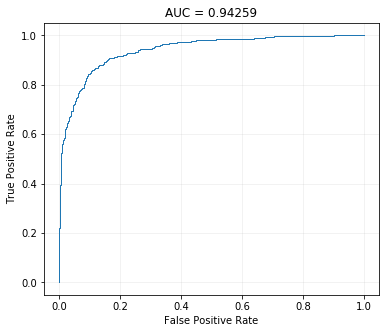

In [505]:
ROC(X_test,Y_test,classifier)

In [506]:
# Classification Metrics
accuracy  = accuracy_score(Y_test, classifier.predict(X_test))
precision = precision_score(Y_test, classifier.predict(X_test),  average="macro")
recall    = recall_score(Y_test, classifier.predict(X_test),  average="macro")
F1        = f1_score(Y_test, classifier.predict(X_test),  average="macro")

print("Accuracy = %0.4f"%accuracy)
print("Precision = %0.4f"%precision)
print("Recall = %0.4f"%recall)
print("F1 Score = %0.4f"%F1)

Accuracy = 0.8750
Precision = 0.8754
Recall = 0.8750
F1 Score = 0.8750


TN: 535
FN: 85
TP: 515
FP: 65


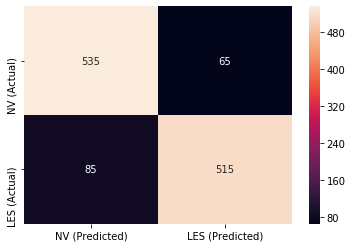

In [507]:
TN, FP, FN, TP = confusion_matrix(Y_test, classifier.predict(X_test)).ravel()
CM = confusion_matrix(Y_test, classifier.predict(X_test))
CM = pd.DataFrame(CM, index = ["NV (Actual)","LES (Actual)"],
                  columns = ["NV (Predicted)","LES (Predicted)"])
sn.heatmap(CM, annot=True, fmt='g')
print("TN: %d"%TN)
print("FN: %d"%FN)
print("TP: %d"%TP)
print("FP: %d"%FP)

## 5-Fold Cross-Validation

In [508]:
full_features_les = np.zeros(shape=(train_features_les.shape[0]+val_features_les.shape[0],train_features_les.shape[1]))
full_features_nv  = np.zeros(shape=(train_features_nv.shape[0]+val_features_nv.shape[0],train_features_nv.shape[1]))

full_features_les[:train_features_les.shape[0],:] = train_features_les
full_features_les[train_features_les.shape[0]:,:] = val_features_les

full_features_nv[:train_features_nv.shape[0],:]   = train_features_nv
full_features_nv[train_features_nv.shape[0]:,:]   = val_features_nv

In [509]:
X, Y               = concat_and_shuffled(class0=full_features_les, class1=full_features_nv, shuffled=True)
X                  = (X-np.mean(X,axis=0))/np.std(X,axis=0)
KFclassifier       = svm.SVC(gamma='scale',probability=True,class_weight='balanced')
scoring_metrics    = ['roc_auc', 'accuracy', 'precision_macro', 'recall_macro', 'f1_macro']
scores             = cross_validate(KFclassifier, X, Y, scoring=scoring_metrics, cv=5)

In [510]:
# Classification Metrics
print("Accuracy = %0.4f"%scores['test_accuracy'].mean())
print("Precision = %0.4f"%scores['test_precision_macro'].mean())
print("Recall = %0.4f"%scores['test_recall_macro'].mean())
print("F1 Score = %0.4f"%scores['test_f1_macro'].mean())
print("ROC(AUC) = %0.4f"%scores['test_roc_auc'].mean())

Accuracy = 0.8730
Precision = 0.8735
Recall = 0.8730
F1 Score = 0.8730
ROC(AUC) = 0.9461


# ● Gabor Filter Response

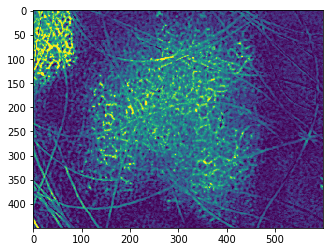

In [468]:
# Gabor Filter Features

img = cv2.cvtColor(cl3, cv2.COLOR_RGB2HSV)
img = img[:,:,:]
gabor_locenergy  = []
gabor_meanamp    = []
filters          = []
kernel_size      = [31, 71, 101]
thetas           = [0, np.pi/8, np.pi/4, 3*np.pi/8, np.pi/2, 5*np.pi/8, 3*np.pi/4, 7*np.pi/8, np.pi/8]
for size in kernel_size:
    for theta in thetas:
        kern = cv2.getGaborKernel((size,size), 5.0, theta, 12.0, 10, 0, ktype=cv2.CV_32F)
        kern /= 1.5*kern.sum()
        filters.append(kern) 
accum = np.zeros_like(img)
for kern in filters:
    fimg        = cv2.filter2D(img, cv2.CV_8UC3, kern)
    gabor_locenergy.append(sum(sum(np.power(fimg[:,:,0],2))))
    gabor_locenergy.append(sum(sum(np.power(fimg[:,:,1],2))))
    gabor_locenergy.append(sum(sum(np.power(fimg[:,:,2],2))))
    gabor_meanamp.append(sum(sum(np.absolute(fimg[:,:,0]))))
    gabor_meanamp.append(sum(sum(np.absolute(fimg[:,:,1]))))
    gabor_meanamp.append(sum(sum(np.absolute(fimg[:,:,2]))))
    np.maximum(accum, fimg, accum)

plt.imshow(accum[:,:,1])